In [1]:
# Character-Level CNN-LSTM model from https://doi.org/10.3390/app131911104

In [2]:
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM, GlobalMaxPooling1D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import re
from html import unescape
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

In [3]:
# Data preprocess
def expand_negations(text):
    
    # Define a list of negations to be expanded
    negations = ["can't", "don't", "won't", "isn't", "aren't", "wasn't", "weren't", "haven't", "hasn't", "hadn't",
                 "couldn't", "shouldn't", "mustn't", "mightn't", "doesn't", "didn't", "ain't", "aint", "shan't"]

    # Create a regular expression pattern to match negations
    negation_pattern = re.compile(r"\b(" + "|".join(negations) + r")\b")

    # Replace each negation with its expanded form
    expanded_text = negation_pattern.sub(lambda x: expand_single_negation(x.group(0)), text)

    return expanded_text

def expand_single_negation(negation):
    # Define a dictionary mapping each negation to its expanded form
    negation_expansions = {
        "can't": "cannot",
        "don't": "do not",
        "won't": "will not",
        "isn't": "is not",
        "aren't": "are not",
        "wasn't": "was not",
        "weren't": "were not",
        "haven't": "have not",
        "hasn't": "has not",
        "hadn't": "had not",
        "couldn't": "could not",
        "shouldn't": "should not",
        "mustn't": "must not",
        "mightn't": "might not",
        "doesn't": "does not",
        "didn't": "did not",
        "ain't": "not",
        "aint": "are not",
        "shan't": "shall not"
    }

    return negation_expansions.get(negation, negation)
    

In [4]:
# Data cleaning from https://doi.org/10.3390/app131911104
def preprocess_text(text):
    
    # Step 1: Decoding HTML
    preprocessed_text = unescape(text)
    
    # Step 2: Removal of emoticons
    preprocessed_text = re.sub(r'[\U00010000-\U0010ffff]', '', preprocessed_text)
    
    # Step 3: Removal of mentions (usernames)
    preprocessed_text = re.sub(r'@\w+', '', preprocessed_text)
    
    # Step 4: Removal of URL links
    preprocessed_text = re.sub(r'https?://\S+|www\.\S+', '', preprocessed_text)
    
    # Step 5: Conversion to lower case
    preprocessed_text = preprocessed_text.lower()
    
    # Step 6: Expansion of negations
    preprocessed_text = expand_negations(preprocessed_text)
    # Add more negations as needed
    
    # Step 7: Removal of hashtags, punctuation marks, numbers, and special characters
    preprocessed_text = re.sub(r'#[\w_]+', '', preprocessed_text)
    preprocessed_text = re.sub(r'[^a-zA-Z\s]', '', preprocessed_text)
    
    # Step 8: Removal of extra white spaces
    preprocessed_text = re.sub(r'\s+', ' ', preprocessed_text).strip()
    
    return preprocessed_text
    

In [5]:
def text_to_one_hot(text):
    
    # English character set
    alphabet = "abcdefghijklmnopqrstuvwxyz "
    unknown_char = "UNK"

    # Create character-to-index mapping
    char_to_index = {char: i for i, char in enumerate(alphabet, start=1)}  # Start index from 1
    char_to_index[unknown_char] = 0  # Index 0 for unknown characters

    # Preprocess input text
    preprocessed_text = preprocess_text(text)

    # Tokenize the text into character indices
    tokenized_text = [char_to_index.get(char.lower(), char_to_index[unknown_char]) for char in preprocessed_text]
    
    # Zero-pad to fix the length to 350 characters -> Max length of input texts is 349 without preprocess, 326 with preprocess
    max_length = 330
    padded_text = pad_sequences([tokenized_text], maxlen=max_length, padding='post', truncating='post')[0]

    # One-hot encoding
    one_hot_encoding = np.eye(len(alphabet) + 1)[padded_text]  # +1 for the unknown character

    return one_hot_encoding
    

In [6]:
# Load datasets
train_df = pd.read_csv("C:\\Users\\aysen\\Documents\\GitHub\\hate_speech_models\\data\\annotations_metadata_train.csv")
test_df = pd.read_csv("C:\\Users\\aysen\\Documents\\GitHub\\hate_speech_models\\data\\annotations_metadata_test.csv")

####################################################################################
train_df['preprocessed_text'] = train_df['text'].apply(preprocess_text)
train_df['num_words'] = train_df['preprocessed_text'].apply(lambda x: len(x.split()))

# Find the entry with the maximum number of words
max_words_entry = train_df['num_words'].idxmax()

# Get the corresponding entry from the DataFrame
max_words_text = train_df.loc[max_words_entry, 'preprocessed_text']

print(f"The entry with the maximum number of words has index: {max_words_entry}")
print(f"The maximum number of words is: {train_df['num_words'].max()}")
print(f"The text of the entry is: {max_words_text}")
####################################################################################

# Text preprocessing
X_train_one_hot = train_df['text'].apply(text_to_one_hot)
X_test_one_hot = test_df['text'].apply(text_to_one_hot)

# Binary label encoding
y_train = (train_df['label'] == 'hate').astype(int)
y_test = (test_df['label'] == 'hate').astype(int)

# Convert pandas series to tensorflow tensors
X_train_tensor = tf.convert_to_tensor(X_train_one_hot.tolist(), dtype=tf.float32)
X_test_tensor = tf.convert_to_tensor(X_test_one_hot.tolist(), dtype=tf.float32)

y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.float32)

The entry with the maximum number of words has index: 1160
The maximum number of words is: 326
The text of the entry is: the reason y i dropped out of school was because either i drop out or i got kicked out i always fought with the packi gang at my school and i was never going to back down in auto class i handed the n igger a monkey wrench and told him the name suited him aswell all the nonwhites hated me because i wore a nazi punk and a white pride patch on my coat and backpack a got in a fight with some black chick and i won the next day her butchy sister caught up with me in the hall way and said that after school her and i where gonna fight i told her no if u wanna fight we re gonna fight right here right now not after school where u can gather the rest of u monkies up so it s an uneven fight she huffed and stormed away we neevr did get to fight the last straw was the first day of school i had a forgein substitute teacher so i was talkin and and this guy was on my case about turni

In [7]:
# Hyperparameters
epochs = 20
batch_size = 32
learning_rate = 0.001
patience = 5
input_shape = (330, 28)

In [8]:
# Char-Level CNN-LSTM Model
char_cnn_lstm_model = Sequential([
    
    # Three convolution layers
    Conv1D(256, kernel_size=3, strides=1, padding='valid', activation='relu', input_shape=input_shape),
    Conv1D(256, kernel_size=3, strides=1, padding='valid', activation='relu'),
    MaxPooling1D(pool_size=3),
    Conv1D(256, kernel_size=3, strides=1, padding='valid', activation='relu'),
    MaxPooling1D(pool_size=3),

    # LSTM layer
    LSTM(100, dropout=0.5, recurrent_dropout=0.5, return_sequences=True),

    # Max-pooling layer
    #MaxPooling1D(pool_size=3),
    # GlobalMaxPooling1D(),
    
    # Flatten layer
    Flatten(),

    # Output layer
    Dense(units=1, activation='sigmoid')
])



In [9]:
# Compile the model
char_cnn_lstm_model.compile(loss='binary_crossentropy',  optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])

# Print the model summary
char_cnn_lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 328, 256)          21760     
                                                                 
 conv1d_1 (Conv1D)           (None, 326, 256)          196864    
                                                                 
 max_pooling1d (MaxPooling1  (None, 108, 256)          0         
 D)                                                              
                                                                 
 conv1d_2 (Conv1D)           (None, 106, 256)          196864    
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 35, 256)           0         
 g1D)                                                            
                                                                 
 lstm (LSTM)                 (None, 35, 100)           1

In [10]:
# Early stopping
callback = EarlyStopping(monitor='val_loss', patience=patience)

# Train the model
char_cnn_lstm_history = char_cnn_lstm_model.fit(X_train_tensor, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)#, callbacks=[callback])

Epoch 1/20


48/48 [==============================] - 8s 90ms/step - loss: 0.6674 - accuracy: 0.6022 - val_loss: 0.6208 - val_accuracy: 0.6371
Epoch 2/20
48/48 [==============================] - 4s 78ms/step - loss: 0.6334 - accuracy: 0.6525 - val_loss: 0.6110 - val_accuracy: 0.6710
Epoch 3/20
48/48 [==============================] - 4s 79ms/step - loss: 0.6191 - accuracy: 0.6636 - val_loss: 0.5876 - val_accuracy: 0.6789
Epoch 4/20
48/48 [==============================] - 4s 75ms/step - loss: 0.5958 - accuracy: 0.6773 - val_loss: 0.5864 - val_accuracy: 0.6736
Epoch 5/20
48/48 [==============================] - 4s 76ms/step - loss: 0.5652 - accuracy: 0.7178 - val_loss: 0.6034 - val_accuracy: 0.6762
Epoch 6/20
48/48 [==============================] - 4s 78ms/step - loss: 0.5105 - accuracy: 0.7655 - val_loss: 0.5730 - val_accuracy: 0.7102
Epoch 7/20
48/48 [==============================] - 4s 82ms/step - loss: 0.4782 - accuracy: 0.7845 - val_loss: 0.6614 - val_accuracy: 0.6997
Epoch 8/20


In [11]:
def plot_results(metrics, title=None, ylabel=None, ylim=None, metric_name=None, color=None):
     
    fig, ax = plt.subplots(figsize=(10, 4))
 
    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]
         
    for idx, metric in enumerate(metrics):    
        ax.plot(metric, color=color[idx])
     
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xlim([0, epochs-1])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)   
    plt.show()
    plt.close()
    

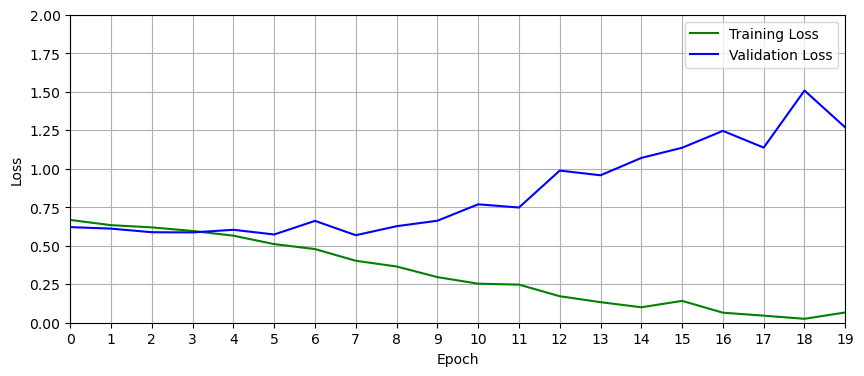

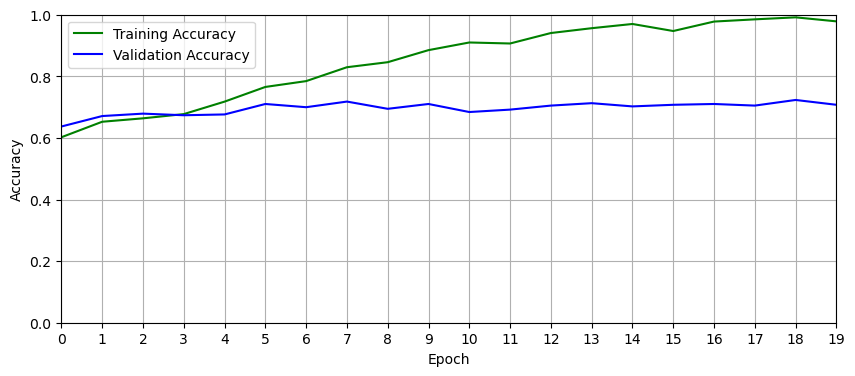

In [12]:
# Retrieve training results
train_loss = char_cnn_lstm_history.history["loss"]
train_acc  = char_cnn_lstm_history.history["accuracy"]
valid_loss = char_cnn_lstm_history.history["val_loss"]
valid_acc  = char_cnn_lstm_history.history["val_accuracy"]
   
plot_results([ train_loss, valid_loss ],        
            ylabel="Loss", 
            ylim = [0.0, 2.0],
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"]);
 
plot_results([ train_acc, valid_acc ], 
            ylabel="Accuracy",
            ylim = [0.0, 1.0],
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"])

In [13]:
test_loss, test_acc = char_cnn_lstm_model.evaluate(X_test_tensor, y_test)
print(f"Test accuracy: {test_acc*100:.3f}")

y_pred = char_cnn_lstm_model.predict(X_test_tensor)
f1 = f1_score(y_test, y_pred.round())
print(f'F1 Score: {f1}')

15/15 [==============================] - 0s 20ms/step - loss: 1.2505 - accuracy: 0.7008
Test accuracy: 70.084
15/15 [==============================] - 1s 19ms/step
F1 Score: 0.7414104882459311


C:\Users\aysen\anaconda3\envs\hate_speech_classification\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\aysen\anaconda3\envs\hate_speech_classification\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\aysen\anaconda3\envs\hate_speech_classification\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\aysen\anaconda3\envs\hate_speech_classification\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be remo